In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pryngles import *
from pryngles import pixx
import time
extension="pixx"
#extension="cpixx"
import multiprocessing as mp
import os,sys,glob
from os import listdir
from os.path import isfile, join
from scipy.optimize import minimize, differential_evolution

# Import local functions
import extra_func as efunc

In [16]:
b = 0.16
aR = 20.3564
orbit_i = np.arccos(b/aR)/Consts.deg
print("Orbit inclination: ", orbit_i)
orbit_i = 90

ring_i = 10
ring_l = 0
gamma, beta_obs, lamb_obs, lamb_star = Util.calcStartingPosition(orbit_i,ring_i,ring_l)

pixx_sys = System()
s=pixx_sys.add(kind="Star",physics=dict(radius=0.75*Consts.rsun/pixx_sys.ul),optics=dict(limb_coeffs=[0.17,0.15]))
p=pixx_sys.add(kind="Planet", primary=s, 
               radius=0.375*Consts.rjupiter/pixx_sys.ul,
               orbit=dict(a=0.071, e=0.22),
               physics=dict(radius=0.375*Consts.rjupiter/pixx_sys.ul),
               optics=dict(nspangles=5000))
r=pixx_sys.add(kind="Ring", primary=p,
               physics=dict(fi=1.5, fe=2.25, i=gamma),
               optics=dict(nspangles=5000))

RP=pixx_sys.ensamble_system(extension=extension, 
                            fname_planet="./fou_files/Planet/fou_bmsca60.0_asurf0.5.dat",
                            fname_ring="./fou_files/Ring/fou_ring_2_0_0_3.dat")
# "./fou_files/Ring/Mie/fou_file_mie_1.5_080_4500_0.05_0.3_60gaus.dat" "./fou_files/Ring/fou_ring_2_0_0_3.dat"
RP.behavior["interp_method_ring"] = "bilinear"
RP.lambq = 0

Orbit inclination:  89.54965420627153


In [18]:
thetap=RP.thetap
thetas=RP.thetas
print("fe: ", RP.fe)
thetar = np.arctan(RP.Rp*RP.fe/RP.rstar)
print("Theta p: ", 2*thetap*180/np.pi)
print("Theta r: ", 2*thetar*180/np.pi)
print("Theta s: ", 2*thetas*180/np.pi)
print(RP.behavior["interp_method_planet"])
print(RP.behavior["interp_method_ring"])

fe:  2.25
Theta p:  0.3708185600187836
Theta r:  0.8343299290335032
Theta s:  7.207494226197241
spline
bilinear


In [6]:
lamb_initial=lamb_star - thetas - 4*RP.fe*RP.thetap
lamb_final=lamb_star + thetas + 4*RP.fe*RP.thetap
lambs = np.linspace(lamb_initial,lamb_final,180)

lq = np.linspace(0,2*np.pi,1000)
d_max = 0
lambq_max = 0
for ii,l in enumerate(lq):
    RP.lambq = l
    RP.changeStellarPosition(lamb_initial)
    d = RP.rstar
    if d >= d_max:
        i_max = ii
        d_max = d
        lambq_max = l
            
RP.lambq = lambq_max
print(i_max,d_max)
print(RP.lambq*180/np.pi)

235 24.834778470177113
84.68468468468468


In [7]:
print(lamb_star/Consts.deg)

lamb_initial=lamb_star - thetas - 4*RP.fe*RP.thetap
lamb_final=lamb_star + thetas + 4*RP.fe*RP.thetap
lambs = np.linspace(lamb_initial,lamb_final,180)

# Initialise the starting position
RP.changeObserver([lamb_obs,beta_obs])
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

Stot  = []
Sp    = []
Sr    = []
Ptot  = []
Pp    = []
Pr    = []
Tp    = []
Tr    = []
T     = []
alpha = []
ts    = []
theta = []
theta0= []
rstar = []

for lamb in lambs:
    RP.changeStellarPosition(lamb)
    print("True anomaly: ", (lamb-lamb_star)/Consts.deg)
    RP._updateGeometricalFactors()
    RP._updateIncomingStellarFlux()
    RP._updateObservedFacetAreas()
    RP.updateReflection(taur=2.0,normalize=False)
    
    back = False 
    if (np.inner(RP.nstar_equ,RP.nr_equ) < 0) ^ (np.inner(RP.nobs_equ,RP.nr_equ) < 0):
        back = True
    print("Is there light transmitted through the ring: ", back)
    print("Illumination: ", np.arccos(abs(RP.etars[0]))/Consts.deg, 
          "Viewing: ", np.arccos(abs(RP.zetars[0]))/Consts.deg)
    #Planet conditions
    condo=(RP.ap)*(RP.ip)

    # Facets that are illuminated through the rings
    condspr = (RP.apsr)*(RP.ips)

    # Facets that are visible but the line of sight is blocked by the rings
    condspo = (RP.apso)*(RP.ip)

    # Facets that are both of the above
    condspb = (RP.apsb)*(~RP.tp)

    cond = condo + condspr + condspo + condspb
    print("Number of planet spangles active: ", cond.sum())
#     if abs(lamb - lamb_star)/Consts.deg < 0.1:
#         RP.plotRingedPlanet(showstar=True,showfig=True)
#         plt.show()
#         plt.close()
            
    print("Minimum azimuthal difference angle: ", np.min(RP.phidiffps)/Consts.deg)
    
    # Save the relevant data
    Stot  += [RP.Stot]
    Sp    += [RP.Stotp]
    Sr    += [RP.Stotr]
    Ptot  += [RP.Ptot]
    Pp    += [RP.Ptotp]
    Pr    += [RP.Ptotr]
    alpha += [np.arccos(RP.alphaps)/Consts.deg]
    ts    += [RP.t*RP.CU.UT]
    theta += [RP.zetars[0]]
    theta0+= [RP.etars[0]]
    rstar += [RP.rstar]
    
    RP.updateTransit()
    Tp += [-RP.Tip.sum()]
    Tr += [-RP.Tir.sum()] 
    T  += [Tp[-1]+Tr[-1] + RP.Stot[0]/1e6]
    
true_anomaly = list((lambs-lamb_star)/Consts.deg)    
save_dict = {"lambda": true_anomaly, "alpha": alpha, "Stot": Stot,
             "Sp": Sp, "Sr": Sr, "Ptot": Ptot, "Pp": Pp, "Pr": Pr,
             "Ttot": T, "Tp": Tp, "Tr": Tr, "Time": ts, "Theta": theta,
             "Theta0": theta0, "Rstar": rstar}

#Pickle the data, if file already exists it will be overwritten
with open("/home/allard/Data/Transit_test/transit_test23.pkl", "wb") as f:
    pickle.dump(save_dict, f)

-90.0000001836389
True anomaly:  -4.943871078323079
Is there light transmitted through the ring:  True
Illumination:  11.144193837295406 Viewing:  10.00000009141332
Number of planet spangles active:  68
Minimum azimuthal difference angle:  -112.12919190562448
True anomaly:  -4.888632295325061
Is there light transmitted through the ring:  True
Illumination:  11.120047316202767 Viewing:  10.00000009141332
Number of planet spangles active:  67
Minimum azimuthal difference angle:  -111.08354101562803
True anomaly:  -4.833393512327029
Is there light transmitted through the ring:  True
Illumination:  11.096120435567052 Viewing:  10.00000009141332
Number of planet spangles active:  65
Minimum azimuthal difference angle:  -109.99861425982333
True anomaly:  -4.77815472932901
Is there light transmitted through the ring:  True
Illumination:  11.072414619463808 Viewing:  10.00000009141332
Number of planet spangles active:  64
Minimum azimuthal difference angle:  -108.87297749387011
True anomaly:  

Is there light transmitted through the ring:  True
Illumination:  10.454816764784816 Viewing:  10.00000009141332
Number of planet spangles active:  40
Minimum azimuthal difference angle:  -75.87661538834406
True anomaly:  -3.0105136733922624
Is there light transmitted through the ring:  True
Illumination:  10.438915860717147 Viewing:  10.00000009141332
Number of planet spangles active:  39
Minimum azimuthal difference angle:  -75.76704239328384
True anomaly:  -2.955274890394244
Is there light transmitted through the ring:  True
Illumination:  10.423280462277862 Viewing:  10.00000009141332
Number of planet spangles active:  38
Minimum azimuthal difference angle:  -75.6534892847851
True anomaly:  -2.9000361073962253
Is there light transmitted through the ring:  True
Illumination:  10.407911766162085 Viewing:  10.00000009141332
Number of planet spangles active:  38
Minimum azimuthal difference angle:  -75.53573591160483
True anomaly:  -2.844797324398194
Is there light transmitted through 

Is there light transmitted through the ring:  True
Illumination:  10.069564289210279 Viewing:  10.00000009141332
Number of planet spangles active:  14
Minimum azimuthal difference angle:  -66.88431427857458
True anomaly:  -1.132395051459477
Is there light transmitted through the ring:  True
Illumination:  10.06326355532921 Viewing:  10.00000009141332
Number of planet spangles active:  14
Minimum azimuthal difference angle:  -66.21160694227595
True anomaly:  -1.0771562684614584
Is there light transmitted through the ring:  True
Illumination:  10.057259186190201 Viewing:  10.00000009141332
Number of planet spangles active:  13
Minimum azimuthal difference angle:  -65.47790428190702
True anomaly:  -1.021917485463427
Is there light transmitted through the ring:  True
Illumination:  10.051551712945948 Viewing:  10.00000009141332
Number of planet spangles active:  12
Minimum azimuthal difference angle:  -64.67479196344236
True anomaly:  -0.9666787024654084
Is there light transmitted through 

Is there light transmitted through the ring:  True
Illumination:  10.023568218885028 Viewing:  10.00000009141332
Number of planet spangles active:  20
Minimum azimuthal difference angle:  -14.491544587251752
True anomaly:  0.7457235704733085
Is there light transmitted through the ring:  True
Illumination:  10.027484580302843 Viewing:  10.00000009141332
Number of planet spangles active:  20
Minimum azimuthal difference angle:  -15.846647767768273
True anomaly:  0.8009623534713398
Is there light transmitted through the ring:  True
Illumination:  10.031700490342795 Viewing:  10.00000009141332
Number of planet spangles active:  21
Minimum azimuthal difference angle:  -17.229420486504356
True anomaly:  0.8562011364693585
Is there light transmitted through the ring:  True
Illumination:  10.036215571479248 Viewing:  10.00000009141332
Number of planet spangles active:  22
Minimum azimuthal difference angle:  -18.639062256199267
True anomaly:  0.9114399194673898
Is there light transmitted throu

Is there light transmitted through the ring:  True
Illumination:  10.335109652229852 Viewing:  10.00000009141332
Number of planet spangles active:  47
Minimum azimuthal difference angle:  -66.93112618256659
True anomaly:  2.6790809754041254
Is there light transmitted through the ring:  True
Illumination:  10.349127367430178 Viewing:  10.00000009141332
Number of planet spangles active:  47
Minimum azimuthal difference angle:  -68.17261293783373
True anomaly:  2.734319758402144
Is there light transmitted through the ring:  True
Illumination:  10.36341755944465 Viewing:  10.00000009141332
Number of planet spangles active:  47
Minimum azimuthal difference angle:  -69.3845984184414
True anomaly:  2.7895585414001753
Is there light transmitted through the ring:  True
Illumination:  10.377979102585773 Viewing:  10.00000009141332
Number of planet spangles active:  48
Minimum azimuthal difference angle:  -70.56707790394894
True anomaly:  2.844797324398194
Is there light transmitted through the r

Is there light transmitted through the ring:  True
Illumination:  10.97983028998446 Viewing:  10.00000009141332
Number of planet spangles active:  70
Minimum azimuthal difference angle:  -175.85285307218507
True anomaly:  4.612438380334942
Is there light transmitted through the ring:  True
Illumination:  11.002637630028557 Viewing:  10.00000009141332
Number of planet spangles active:  72
Minimum azimuthal difference angle:  -176.0568204466517
True anomaly:  4.667677163332961
Is there light transmitted through the ring:  True
Illumination:  11.025671717994495 Viewing:  10.00000009141332
Number of planet spangles active:  72
Minimum azimuthal difference angle:  -176.23752596936396
True anomaly:  4.722915946330992
Is there light transmitted through the ring:  True
Illumination:  11.048931135580133 Viewing:  10.00000009141332
Number of planet spangles active:  72
Minimum azimuthal difference angle:  -176.39873160362916
True anomaly:  4.77815472932901
Is there light transmitted through the 

<IPython.core.display.Javascript object>


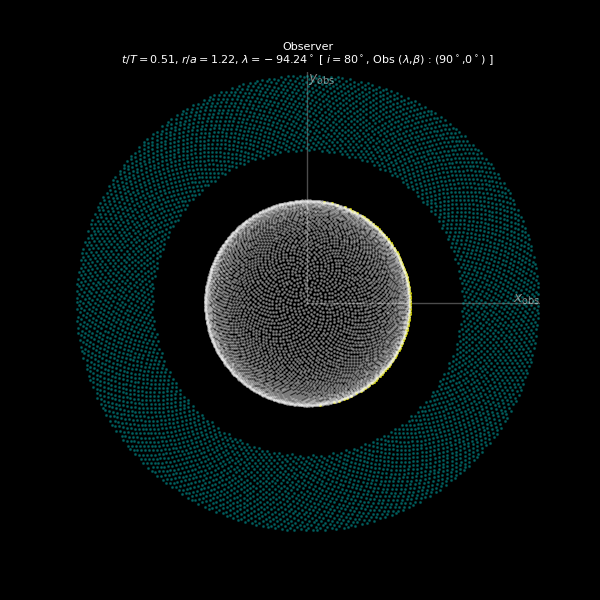

<IPython.core.display.Javascript object>


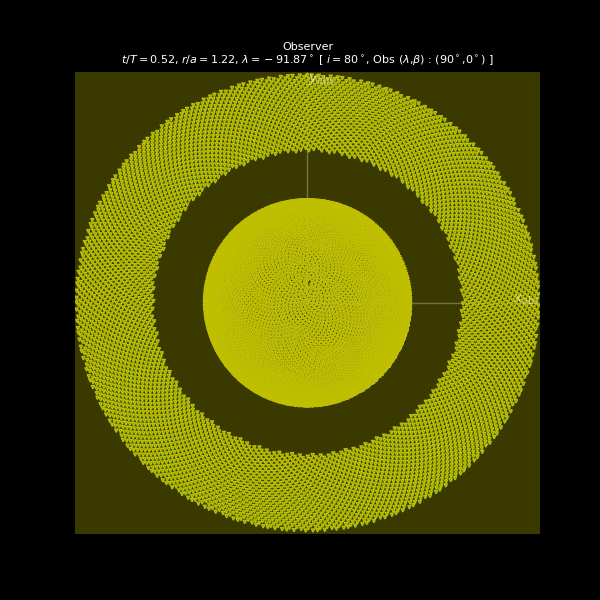

<IPython.core.display.Javascript object>


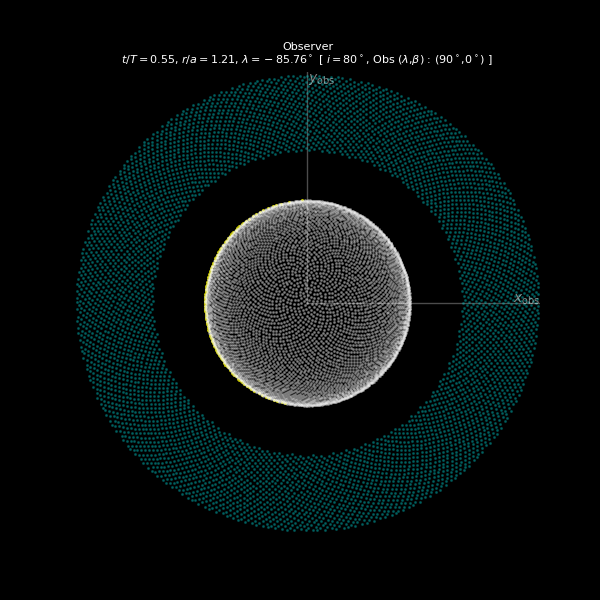

In [45]:
RP.changeStellarPosition(lamb_initial)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

junk1,fig,junk2 = RP.plotRingedPlanet(showstar=True,showfig=False)
fig.show()

RP.changeStellarPosition(lambs[int(len(lambs)/2)-40])
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

junk1,fig,junk2 = RP.plotRingedPlanet(showstar=True,showfig=False)
fig.show()

RP.changeStellarPosition(lamb_final)
RP._updateGeometricalFactors()
RP._updateIncomingStellarFlux()
RP._updateObservedFacetAreas()

junk1,fig,junk2 = RP.plotRingedPlanet(showstar=True,showfig=False)
fig.show()

<IPython.core.display.Javascript object>


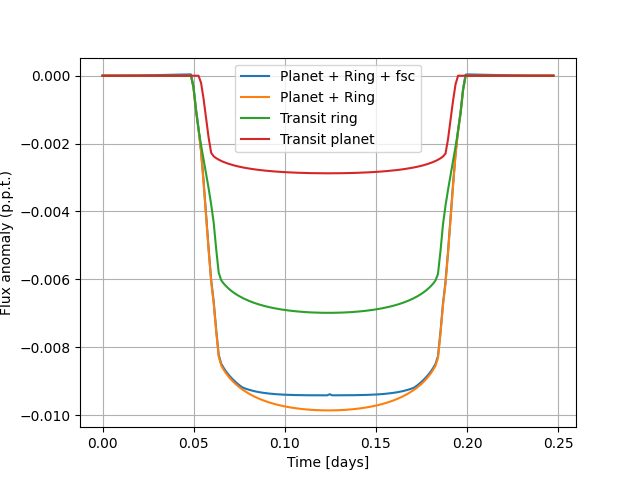

<IPython.core.display.Javascript object>


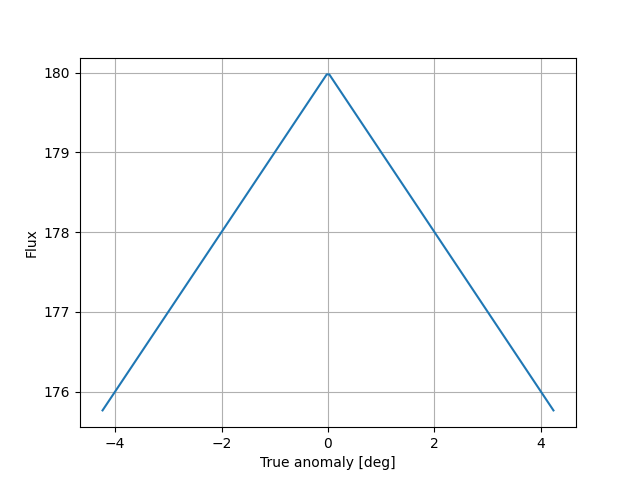

179.97633731292416
2.081213222295913e-06


In [27]:
pc = 206265 # parsec in AU
# Rs = 0.75*Consts.rsun/pixx_sys.ul # Stellar radius in AU
pcRs = 1#np.sqrt(1e-3)#9.79*pc/Rs # parsec in stellar radius

fig1=plt.figure()
ax1=fig1.gca()

fig2=plt.figure()
ax2=fig2.gca()

data_name = "/home/allard/Data/Transit_test/transit_test19.pkl"
with open(data_name,"rb") as f:
    save_file = pickle.load(f)

true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Stot  = np.array(save_file["Stot"])
Sp    = np.array(save_file["Sp"])
Sr    = np.array(save_file["Sr"])
Ptot  = np.array(save_file["Ptot"])
Pp    = np.array(save_file["Pp"])
Pr    = np.array(save_file["Pr"])
Ttot  = np.array(save_file["Ttot"])
Tp    = np.array(save_file["Tp"])
Tr    = np.array(save_file["Tr"])
ts    = np.array(save_file["Time"])
theta = np.arccos(np.array(save_file["Theta"]))*180/np.pi
theta0= np.arccos(np.array(save_file["Theta0"]))*180/np.pi
rstar = np.array(save_file["Rstar"])
ts=(ts-ts[0])/Consts.day

ax1.plot(ts, Ttot/pcRs**2, label="Planet + Ring + fsc")
ax1.plot(ts, Tr/pcRs**2 + Tp/pcRs**2, label="Planet + Ring")
ax1.plot(ts, Tr/pcRs**2, label="Transit ring")
ax1.plot(ts, Tp/pcRs**2, label="Transit planet")
ax1.legend()
ax1.set_ylabel("Flux anomaly (p.p.t.)")
ax1.set_xlabel("Time [days]")
ax1.grid()


# ax2.plot(ts, Stot[:,0]/1e6, label="Forward scattering")
# ax2.plot(true_anomaly, Stot[:,0]/1e6, label="Forward scattering")
# ax2.plot(180- alpha, Stot[:,0]/1e6, label="Forward scattering")
# ax2.plot(rstar,Stot[:,0]/1e6,label="Forward scattering")
ax2.plot(true_anomaly, theta0, label="Theta0")
# ax2.plot(180- alpha, theta0, label="Theta0")
# ax2.plot(ts,theta+theta0)
# ax2.plot(ts, Sp[:,0]/1e6, label="Planet")
# ax2.plot(ts, Sr[:,0]/1e6, label="Ring")

# ax2.legend()
ax2.grid()
ax2.set_ylabel("Flux")
ax2.set_xlabel("True anomaly [deg]")
# ax2.set_yscale('log')
plt.plot()
print(np.max(theta0))
print(np.min(Stot[:,0]/1e6))
# print(np.max(Stot[:,0]),np.max(Stot[:,0]/1e6*4*np.pi*RP.rstar**2/(np.pi*RP.Rp**2)))

5981


<IPython.core.display.Javascript object>


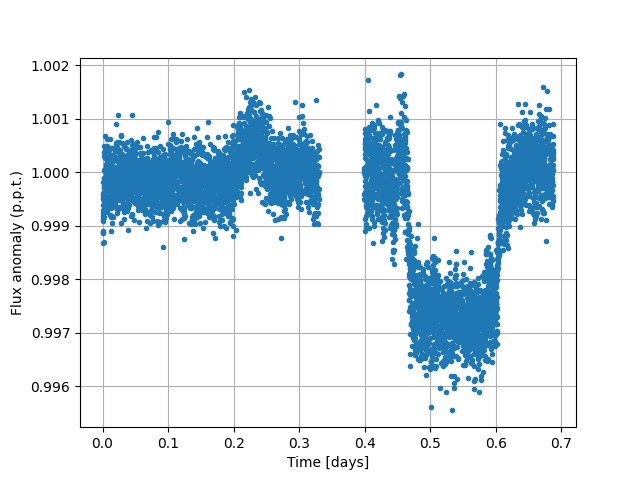

In [22]:
file_spitzer_1 = "n20190210.Spit45.Spitzer.b_first_detrend.dat"
file_spitzer_2 = "n20190227.Spit45.Spitzer_second.b_detrend.dat" # Misses ingress
file_spitzer_3 = "n20190909.Spit45.Spitzer_third_plus_extra.b_detrend.dat"

file_tess_1 = "n20180726.TESS.TESS.b.dat"
file_tess_2 = "n20180812.TESS.TESS.b.dat"
file_tess_3 = "n20200710.TESS.TESS.b.dat"
file_tess_4 = "n20200719.TESS.TESS.b.dat"
file_tess_5 = "n20200727.TESS.TESS.b.dat"
data_name = f"./transit_data/{file_spitzer_3}"
time = []
flux = []
flux_err = []
ii = 0
for line in open(data_name).readlines():
    if ii > 1:
        sp = line.split()
        time += [float(sp[0])]
        flux += [float(sp[1])]
        flux_err += [float(sp[2])]
    ii += 1
        
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)
print(len(flux))
time = time - time[0]

fig1=plt.figure()
ax1=fig1.gca()

ax1.plot(time,flux, '.')
# ax1.plot(time,flux, '.')
#ax1.plot(ts+0.38014503, Ttot+1, label="Planet + Ring + fsc")
# ax1.plot(ts+0.38, Tr + Tp + 1, label="Planet + Ring")
# ax1.plot(ts, Tr + 1, label="Transit ring")
#ax1.plot(ts+0.38131849, Tp + 1, label="Transit planet")
# ax1.legend()
ax1.set_ylabel("Flux anomaly (p.p.t.)")
ax1.set_xlabel("Time [days]")
ax1.grid()
plt.show()

# ax1.set_xlim([0.4,0.7])

# fig2=plt.figure()
# ax2=fig2.gca()
# y = np.interp(time[3059:],ts+0.38131849,Tp+1)
# ax2.plot(time[3059:],flux[3059:], '.',label="original data")
# ax2.plot(time[3059:],y, '.',label="interpolated")
# ax2.plot(ts+0.38131849, Tp + 1, '.',label="Model")
# ax2.legend()
# ax2.grid()

# print("RMS: ", np.sqrt(np.sum((y-flux[3059:])**2)/len(y)))

In [35]:
def func(x,time,ts,Tp,flux):
    return np.sqrt(np.sum((np.interp(time,ts+x,Tp)-flux)**2)/len(flux))
res = minimize(func, 0.38, args = (time[3059:],ts,Ttot+1,flux[3059:]))
print(res.x)
print(res.fun)

[0.38014503]
0.0007108266184317812


## Fit a curve to the data

In [3]:
"""
x = [b,ring_i,ring_l,r,a,e,fi,fe,lincoef,quadcoef,optical_th]
x[0] = b ; impact parameter
x[1] = ring_i ; ring_inclination
x[2] = ring_l ; ring roll
x[3] = r ; planetary radius, in terms of the radius of jupiter
x[4] = a ; semi-major axis of the orbit
x[5] = e ; eccentricity of the orbit
x[6] = fi ; inner radius of ring, in terms of planetary radius
x[7] = fe ; outer radius of ring, in terms of planetary radius
x[8] = lincoef ; linear limb-darkening coefficient
x[9] = quadcoef ; quadratic limb-darkening coefficient
x[10] = optical_th ; optical thickness of the ring
x[11] = particle_r ; radius of the particles

fitx = x-array of observations
fity = y-array of observations
"""
file_spitzer_1 = "n20190210.Spit45.Spitzer.b_first_detrend.dat"
file_spitzer_2 = "n20190227.Spit45.Spitzer_second.b_detrend.dat" # Misses ingress
file_spitzer_3 = "n20190909.Spit45.Spitzer_third_plus_extra.b_detrend.dat"

file_tess_1 = "n20180726.TESS.TESS.b.dat"
file_tess_2 = "n20180812.TESS.TESS.b.dat"
file_tess_3 = "n20200710.TESS.TESS.b.dat"
file_tess_4 = "n20200719.TESS.TESS.b.dat"
file_tess_5 = "n20200727.TESS.TESS.b.dat"
data_name = f"./transit_data/{file_spitzer_3}"
time = []
flux = []
flux_err = []
ii = 0
for line in open(data_name).readlines():
    if ii > 1:
        sp = line.split()
        time += [float(sp[0])]
        flux += [float(sp[1])]
        flux_err += [float(sp[2])]
    ii += 1
        
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)

time = time - time[0]

time = time[3059:]
flux = flux[3059:]

"""
    Used numbers: 
    0 (seed=1), 
    1 (seed=2, with x0, changed mutation parameters: mutation to (0.2,1.2), recombination to 0.5),
    2 (seed=2, fixed optical thickness problem in funtion, same parameters as number 1),
    3 (seed=3, popsize=42, mutation=(0.1,1.5), recombination=0.4),
    4 (local optimization, Nelder-Mead, x0=x0_best, bounds=range of 10 best),
    5 (local optimization, CG),
    6 (local optimization, L-BFGS-B),
    7 (local optimization, CG with second best solution of run3),
    8 (seed=3, fixed problem with ring flux (was too high)),
    9 (seed=3, fixed problem with ring flux (forgot ppm)),
    10 (seed=3, mie scattering files, changed function, added integrality),
    11 (seed=4, mie scattering files, 12 workers, fixed silent errors(?)),
"""

run_num = 11 

bounds = [(0.05, 0.3), (1, 89), (-89, 89), (0.357, 0.393), (0.06, 0.073), (0.01, 0.27),
          (1.2, 2), (2.01, 4), (0.05, 0.39), (0.0, 0.42), (0, 11), (0,2)]
integrality_list = [False,False,False,False,False,False,False,False,False,False,True,True]
# x0 = np.array([0.10645218671168435, 85.75714378158361, -47.207062778137455, 
#                0.3588572642933622, 0.07286797356148741, 0.2682722687112035, 
#                1.790851434272016, 2.2350936289290684, 0.10248150639214178, 
#                0.3478243627829524, -0.8829359719086392])
result = differential_evolution(efunc.transitFitMie, bounds, args=(time,flux,run_num,), popsize=48,
                                updating='deferred',mutation=(0.1,1.5),recombination=0.4,
                                workers=12,seed=4,disp=True,integrality=integrality_list)#, x0=x0_best)

differential_evolution step 1: f(x)= 0.000505639
differential_evolution step 2: f(x)= 0.000505639
differential_evolution step 3: f(x)= 0.000499041
differential_evolution step 4: f(x)= 0.000499041
differential_evolution step 5: f(x)= 0.000497731
differential_evolution step 6: f(x)= 0.000497731
differential_evolution step 7: f(x)= 0.000497731
differential_evolution step 8: f(x)= 0.000497731
differential_evolution step 9: f(x)= 0.000497731
differential_evolution step 10: f(x)= 0.000497731
differential_evolution step 11: f(x)= 0.000497731
differential_evolution step 12: f(x)= 0.000497685
differential_evolution step 13: f(x)= 0.000497546
differential_evolution step 14: f(x)= 0.000497546
differential_evolution step 15: f(x)= 0.000497546
differential_evolution step 16: f(x)= 0.000497546
differential_evolution step 17: f(x)= 0.000497539



KeyboardInterrupt



## Local optimization of results

In [ ]:
"""
x = [b,ring_i,ring_l,r,a,e,fi,fe,lincoef,quadcoef,optical_th]
x[0] = b ; impact parameter
x[1] = ring_i ; ring_inclination
x[2] = ring_l ; ring roll
x[3] = r ; planetary radius, in terms of the radius of jupiter
x[4] = a ; semi-major axis of the orbit
x[5] = e ; eccentricity of the orbit
x[6] = fi ; inner radius of ring, in terms of planetary radius
x[7] = fe ; outer radius of ring, in terms of planetary radius
x[8] = lincoef ; linear limb-darkening coefficient
x[9] = quadcoef ; quadratic limb-darkening coefficient
x[10] = optical_th ; optical thickness of the ring

fitx = x-array of observations
fity = y-array of observations
"""
file_spitzer_1 = "n20190210.Spit45.Spitzer.b_first_detrend.dat"
file_spitzer_2 = "n20190227.Spit45.Spitzer_second.b_detrend.dat" # Misses ingress
file_spitzer_3 = "n20190909.Spit45.Spitzer_third_plus_extra.b_detrend.dat"

data_name = f"./transit_data/{file_spitzer_3}"
time = []
flux = []
flux_err = []
ii = 0
for line in open(data_name).readlines():
    if ii > 1:
        sp = line.split()
        time += [float(sp[0])]
        flux += [float(sp[1])]
        flux_err += [float(sp[2])]
    ii += 1
        
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)

time = time - time[0]

time = time[3059:]
flux = flux[3059:]
"""
    Used numbers: 
    0 (seed=1), 
    1 (seed=2, with x0, changed mutation parameters: mutation to (0.2,1.2), recombination to 0.5),
    2 (seed=2, fixed optical thickness problem in funtion, same parameters as number 1),
    3 (seed=3, popsize=42, mutation=(0.1,1.5), recombination=0.4),
    4 (local optimization, Nelder-Mead, x0=x0_best, bounds=range of 10 best),
    5 (local optimization, CG),
    6 (local optimization, L-BFGS-B)
"""
run_num = 4 

bounds = [(avg_x[0]-std_x[0], avg_x[0]+std_x[0]), (avg_x[1]-std_x[1], avg_x[1]+std_x[1]), 
          (avg_x[2]-std_x[2], avg_x[2]+std_x[2]), (avg_x[3]-std_x[3], avg_x[3]+std_x[3]), 
          (avg_x[4]-std_x[4], avg_x[4]+std_x[4]), (avg_x[5]-std_x[5], avg_x[5]+std_x[5]), 
          (avg_x[6]-std_x[6], avg_x[6]+std_x[6]), (avg_x[7]-std_x[7], avg_x[7]+std_x[7]), 
          (avg_x[8]-std_x[8], avg_x[8]+std_x[8]), (avg_x[9]-std_x[9], avg_x[9]+std_x[9]), 
          (10**(avg_x[10]-std_x[10]), 10**(avg_x[10]+std_x[10]))]
# x0 = np.array([0.10645218671168435, 85.75714378158361, -47.207062778137455, 
#                0.3588572642933622, 0.07286797356148741, 0.2682722687112035, 
#                1.790851434272016, 2.2350936289290684, 0.10248150639214178, 
#                0.3478243627829524, -0.8829359719086392])
result = minimize(efunc.transitFit, x0_best, args=(time,flux,run_num,), method="Nelder-Mead", 
                  tol=1e-6, bounds=bounds)

# Check fitted curves

## Redo transit to obtain all information

In [3]:
# Load fit data
file_spitzer_3 = "n20190909.Spit45.Spitzer_third_plus_extra.b_detrend.dat"
data_name = f"./transit_data/{file_spitzer_3}"
time = []
flux = []
flux_err = []
ii = 0
for line in open(data_name).readlines():
    if ii > 1:
        sp = line.split()
        time += [float(sp[0])]
        flux += [float(sp[1])]
        flux_err += [float(sp[2])]
    ii += 1
        
time = np.array(time)
flux = np.array(flux)
flux_err = np.array(flux_err)

time = time - time[0]
time = time[3059:]
flux = flux[3059:]

# Best fit of first run
fit_file1 = "/home/allard/Data/Transit_fit/run_num0/rn0_fitness0.000522_x1_79.6_x2_86.07_fi1.80_fe2.14_e0.230_.pkl"
fit_file2 = "/home/allard/Data/Transit_fit/run_num0/rn0_fitness0.000525_x1_85.8_x2_-47.21_fi1.79_fe2.24_e0.268_.pkl"
with open(fit_file2,"rb") as f:
    save_file = pickle.load(f)
x = save_file["x"]

# Generate data from parameters
fit = efunc.transitFit(x,time,flux,0,save_everything=True)


KeyboardInterrupt



b = 0.10511817288286357 ; impact parameter 
ring_i = 85.75714378158361 ; ring_inclination 
ring_l = -47.207062778137455 ; ring roll 
r = 0.3588572642933622 ; planetary radius, in terms of the radius of jupiter 
a = 0.07286797356148741 ; semi-major axis of the orbit 
e = 0.2682722687112035 ; eccentricity of the orbit 
fi = 1.790851434272016 ; inner radius of ring, in terms of planetary radius 
fe = 2.2350936289290684 ; outer radius of ring, in terms of planetary radius 
lincoef = 0.10248150639214178 ; linear limb-darkening coefficient 
quadcoef = 0.3478243627829524 ; quadratic limb-darkening coefficient 
optical_th = -0.8829359719086392 ; optical thickness of the ring


<IPython.core.display.Javascript object>


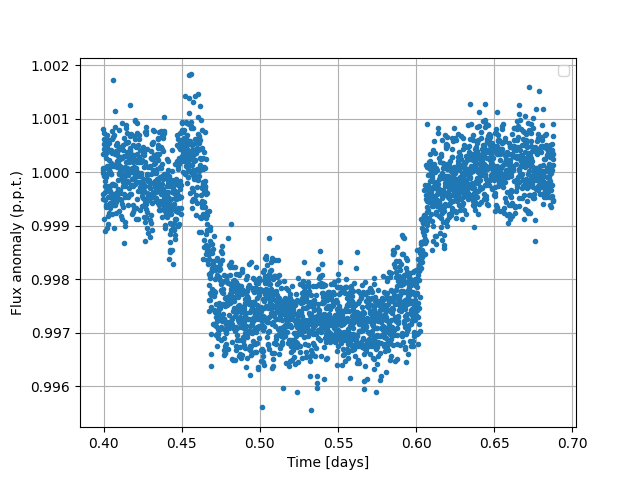

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [4]:
# Best fit : rn0_fitness0.000522_x1_79.6_.pkl
# 2nd      : rn0_fitness0.000525_x1_85.8_.pkl
save_name = "/home/allard/Data/Transit_fit_checked/run_num0/rn0_fitness0.000525_x1_85.8_.pkl"
with open(save_name,"rb") as f:
    save_file = pickle.load(f)
    
true_anomaly = np.array(save_file["lambda"])
alpha = np.array(save_file["alpha"])
Stot = np.array(save_file["Stot"])
Sp   = np.array(save_file["Sp"])
Sr   = np.array(save_file["Sr"])
Ptot = np.array(save_file["Ptot"])
Pp   = np.array(save_file["Pp"])
Pr   = np.array(save_file["Pr"])
Ttot = np.array(save_file["Ttot"])
Tp   = np.array(save_file["Tp"])
Tr   = np.array(save_file["Tr"])
ts   = np.array(save_file["Time"])
fitx = save_file["Fitx"]
fity = save_file["Fity"]
x    = save_file["x"]
shift = save_file["Shift"]

print(
    f"b = {x[0]} ; impact parameter \n" +\
    f"ring_i = {x[1]} ; ring_inclination \n" +\
    f"ring_l = {x[2]} ; ring roll \n" +\
    f"r = {x[3]} ; planetary radius, in terms of the radius of jupiter \n" +\
    f"a = {x[4]} ; semi-major axis of the orbit \n" +\
    f"e = {x[5]} ; eccentricity of the orbit \n" +\
    f"fi = {x[6]} ; inner radius of ring, in terms of planetary radius \n" +\
    f"fe = {x[7]} ; outer radius of ring, in terms of planetary radius \n" +\
    f"lincoef = {x[8]} ; linear limb-darkening coefficient \n" +\
    f"quadcoef = {x[9]} ; quadratic limb-darkening coefficient \n" +\
    f"optical_th = {x[10]} ; optical thickness of the ring" 
    )

fig1=plt.figure()
ax1=fig1.gca()

ax1.plot(fitx,fity, '.')
# ax1.plot(ts+shift, Ttot+1, label="Best fit")
ax1.legend()
ax1.set_ylabel("Flux anomaly (p.p.t.)")
ax1.set_xlabel("Time [days]")
ax1.grid()
plt.show()

## Plot best fits

<IPython.core.display.Javascript object>


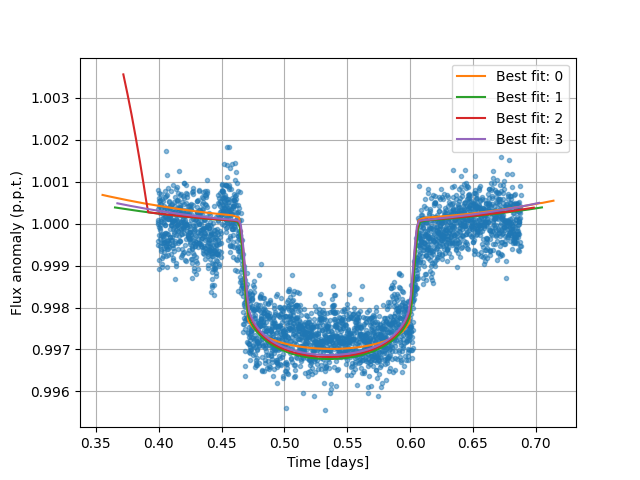

b = 0.07109637326961996 ; impact parameter 
ring_i = 87.92773594225879 ; ring_inclination 
ring_l = -71.31559675229228 ; ring roll 
r = 0.3783593393353345 ; planetary radius, in terms of the radius of jupiter 
a = 0.06655479012215455 ; semi-major axis of the orbit 
e = 0.261776497438356 ; eccentricity of the orbit 
fi = 1.6285032610682473 ; inner radius of ring, in terms of planetary radius 
fe = 2.6172882592574633 ; outer radius of ring, in terms of planetary radius 
lincoef = 0.20557187469851998 ; linear limb-darkening coefficient 
quadcoef = 0.08672790731023632 ; quadratic limb-darkening coefficient 
optical_th = 0.1298927036485868 ; optical thickness of the ring 

Average value of the parameters 
b = 0.08 +- 0.0183 ; impact parameter 
ring_i = 86.7868 +- 2.4319 ; ring_inclination 
ring_l = 37.7178 +- 63.2998 ; ring roll 
r = 0.3777 +- 0.0013 ; planetary radius, in terms of the radius of jupiter 
a = 0.0685 +- 0.0024 ; semi-major axis of the orbit 
e = 0.2484 +- 0.0128 ; eccentricit

In [8]:
def extractPlot(save_name,number):
    onlyfiles = np.array([f for f in listdir(save_name) if isfile(join(save_name, f))])
    sortedfiles = np.sort(onlyfiles)
    x_sum = np.zeros((11,number))
    
    fig1=plt.figure()
    ax1=fig1.gca()
    
    for i in np.arange(number):
        fitfile_name = save_name + "/" + sortedfiles[i]
        with open(fitfile_name,"rb") as f:
            save_file = pickle.load(f)
        fitx = save_file["Fitx"]
        fity = save_file["Fity"]
        shift = save_file["Shift"]
        x = save_file["x"]
        Ttot = np.array(save_file["Ttot"])
        ts   = np.array(save_file["Time"])
        x_sum[:,i] = x
        if i == 0:
            x0_best=x
            ax1.plot(fitx,fity,'.', alpha=0.5)
            print(
                f"b = {x[0]} ; impact parameter \n" +\
                f"ring_i = {x[1]} ; ring_inclination \n" +\
                f"ring_l = {x[2]} ; ring roll \n" +\
                f"r = {x[3]} ; planetary radius, in terms of the radius of jupiter \n" +\
                f"a = {x[4]} ; semi-major axis of the orbit \n" +\
                f"e = {x[5]} ; eccentricity of the orbit \n" +\
                f"fi = {x[6]} ; inner radius of ring, in terms of planetary radius \n" +\
                f"fe = {x[7]} ; outer radius of ring, in terms of planetary radius \n" +\
                f"lincoef = {x[8]} ; linear limb-darkening coefficient \n" +\
                f"quadcoef = {x[9]} ; quadratic limb-darkening coefficient \n" +\
                f"optical_th = {10**x[10]} ; optical thickness of the ring \n" 
                )
        ax1.plot(ts+shift, Ttot+1, label=f"Best fit: {i}")
    ax1.legend()
    ax1.set_ylabel("Flux anomaly (p.p.t.)")
    ax1.set_xlabel("Time [days]")
    ax1.grid()
    plt.show()
    
    avg_x = np.mean(x_sum, axis=1)
    std_x = np.std(x_sum,axis=1)
    print( f"Average value of the parameters \n" + \
        f"b = {round(avg_x[0],4)} +- {round(std_x[0],4)} ; impact parameter \n" +\
        f"ring_i = {round(avg_x[1],4)} +- {round(std_x[1],4)} ; ring_inclination \n" +\
        f"ring_l = {round(avg_x[2],4)} +- {round(std_x[2],4)} ; ring roll \n" +\
        f"r = {round(avg_x[3],4)} +- {round(std_x[3],4)} ; planetary radius, in terms of the radius of jupiter \n" +\
        f"a = {round(avg_x[4],4)} +- {round(std_x[4],4)} ; semi-major axis of the orbit \n" +\
        f"e = {round(avg_x[5],4)} +- {round(std_x[5],4)} ; eccentricity of the orbit \n" +\
        f"fi = {round(avg_x[6],4)} +- {round(std_x[6],4)} ; inner radius of ring, in terms of planetary radius \n" +\
        f"fe = {round(avg_x[7],4)} +- {round(std_x[7],4)} ; outer radius of ring, in terms of planetary radius \n" +\
        f"lincoef = {round(avg_x[8],4)} +- {round(std_x[8],4)} ; linear limb-darkening coefficient \n" +\
        f"quadcoef = {round(avg_x[9],4)} +- {round(std_x[9],4)} ; quadratic limb-darkening coefficient \n" +\
        f"optical_th = {round(10**avg_x[10],4)} +- {round(10**avg_x[10]-10**(avg_x[10]-std_x[10]),4)} ; optical thickness of the ring" 
    )
    return x0_best,avg_x,std_x
    
save_name = "/home/allard/Data/Transit_fit/run_num8"
x0_best,avg_x,std_x = extractPlot(save_name,4)